In [1]:
import os
import sys
import time
import random
import warnings

import cv2 as cv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import backend as K
from sklearn.model_selection import train_test_split

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
def acc_comp(msk, preds_test_t): #Takes as input 2D masks and 2D predictions
    
    mean_acc = np.zeros(1)
    mean_TP = np.zeros(1)
    mean_TN = np.zeros(1)
    mean_FP = np.zeros(1)
    mean_FN = np.zeros(1)
    
    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)
    
        c = act == pr #acc
        d = act & pr #true negative
        e = act | pr #true positive
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TN = round(float(d.sum()),6)
        FN = round(float(pr.sum()-d.sum()),6)
        TP = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FP = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

        acc2 = float(TP+TN)/(TP+TN+FP+FN)
        mean_TP = np.append([mean_TP],TP)
        mean_TN = np.append([mean_TN],TN)
        mean_acc = np.append([mean_acc],acc)
        mean_FP = np.append([mean_FP],FP)
        mean_FN = np.append([mean_FN],FN)
    
    mean_acc = mean_acc[1:]
    mean_TP = mean_TP[1:]
    mean_TN = mean_TN[1:]
    mean_FP = mean_FP[1:]
    mean_FN = mean_FN[1:]
    
    avg = round(mean_acc.sum()/msk.shape[0],6)
    std = round(np.std(mean_acc),6)
    overall_TP = round(mean_TP.sum()/msk.shape[0],6)
    overall_TN = round(mean_TN.sum()/msk.shape[0],6)
    
    return (avg,std,mean_TP,mean_TN,mean_FP,mean_FN)

In [3]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback()

In [4]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [5]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Dataset 7: FSD
TRAIN_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/original_images/']
MASK_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/skin_masks/']
train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
train_ids7.sort()
mask_ids7.sort()
TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
MASK_PATH7 = MASK_PATH7*len(train_ids7)

# Dataset 8: ABDOMEN
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

# Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH8,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7))
# MASK_PATH = np.concatenate((MASK_PATH8,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH1,MASK_PATH7))
# train_ids = np.concatenate((train_ids8,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids1,train_ids7))
# mask_ids = np.concatenate((mask_ids8,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids1,mask_ids7))

TRAIN_PATH = np.concatenate((TRAIN_PATH8,TRAIN_PATH4,TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH5,TRAIN_PATH7))
MASK_PATH = np.concatenate((MASK_PATH8,MASK_PATH4,MASK_PATH6,MASK_PATH1,MASK_PATH5,MASK_PATH7))
train_ids = np.concatenate((train_ids8,train_ids4,train_ids6,train_ids1,train_ids5,train_ids7))
mask_ids = np.concatenate((mask_ids8,mask_ids4,mask_ids6,mask_ids1,mask_ids5,mask_ids7))

TRAIN_PATH = TRAIN_PATH[:-100]
MASK_PATH = MASK_PATH[:-100]
train_ids = train_ids[:-100]
mask_ids = mask_ids[:-100]

In [ ]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    path = MASK_PATH[n] + id_
    img = imread(path)
#     if n in range(0,78):
#         img = img[:,:,1]
    if n in range(500,578): # When using all datasets
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[n] = img > 30    # Important, Needed to make labels 0's and 1's only

In [61]:
# MANUAL PERMUTATION
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
DATA = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 4))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
g = list(range(0,len(train_ids)))
np.random.shuffle(g)

strs_original = ["" for x in range(len(train_ids))]
strs_mask = ["" for x in range(len(train_ids))]
pathmsk = MASK_PATH[0] + mask_ids[0]
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    strs_mask[n] = MASK_PATH[n] + mask_ids[n]
    strs_original[n] = TRAIN_PATH[n] + train_ids[n]
    
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = strs_original[g[n]]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    path = strs_mask[g[n]]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        img = img > 30     # Important, Needed to make labels 0's and 1's only   
    else:
        img = img > 0
    Y_train[n] = img      

Getting and resizing train images and masks ... 


In [5]:
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

In [6]:
TRAIN_PATH = TRAIN_PATH8
MASK_PATH = MASK_PATH8
train_ids = train_ids8
mask_ids = mask_ids8

# Add abodmen pictures to the beginning
X_train1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train1 = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + train_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train1[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        img = img > 30     # Important, Needed to make labels 0's and 1's only   
    else:
        img = img > 0
    Y_train1[n] = img   
    
X_train = np.concatenate((X_train1,X_train),axis=0)
Y_train = np.concatenate((Y_train1,Y_train),axis=0)

Getting and resizing train images and masks ... 


NameError: name 'X_train' is not defined

In [7]:
X_train = X_train1
Y_train = Y_train1

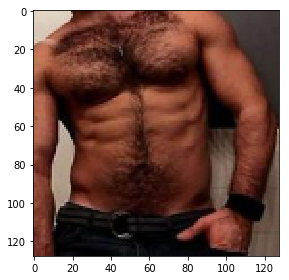

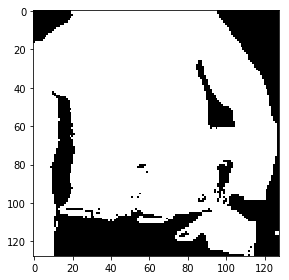

In [10]:
# Check if training data looks all right
# train_ids = np.concatenate((train_ids8,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids7,train_ids1))
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [11]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [12]:
# Fit model
earlystopper = EarlyStopping(patience=30, verbose=1)
checkpointer = ModelCheckpoint('onlyabd.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=64, epochs=50, shuffle=True, 
                    callbacks=[earlystopper, checkpointer, cb])

Train on 604 samples, validate on 152 samples
Epoch 1/50
604/604 [==============================] - 30s 50ms/step - loss: 0.6236 - acc: 0.6520 - val_loss: 0.6131 - val_acc: 0.6145

Epoch 00001: val_loss improved from inf to 0.61313, saving model to onlyabd.h5
Epoch 2/50
604/604 [==============================] - 28s 47ms/step - loss: 0.4385 - acc: 0.8057 - val_loss: 0.4618 - val_acc: 0.8334

Epoch 00002: val_loss improved from 0.61313 to 0.46179, saving model to onlyabd.h5
Epoch 3/50
604/604 [==============================] - 28s 47ms/step - loss: 0.3383 - acc: 0.8772 - val_loss: 0.5530 - val_acc: 0.7821

Epoch 00003: val_loss did not improve from 0.46179
Epoch 4/50
604/604 [==============================] - 29s 47ms/step - loss: 0.3335 - acc: 0.8715 - val_loss: 0.4104 - val_acc: 0.8410

Epoch 00004: val_loss improved from 0.46179 to 0.41042, saving model to onlyabd.h5
Epoch 5/50
604/604 [==============================] - 28s 47ms/step - loss: 0.3075 - acc: 0.8833 - val_loss: 0.3824 - 


Epoch 00041: val_loss did not improve from 0.22823
Epoch 42/50
604/604 [==============================] - 28s 47ms/step - loss: 0.1239 - acc: 0.9523 - val_loss: 0.2413 - val_acc: 0.9172

Epoch 00042: val_loss did not improve from 0.22823
Epoch 43/50
604/604 [==============================] - 28s 47ms/step - loss: 0.1198 - acc: 0.9547 - val_loss: 0.2320 - val_acc: 0.9197

Epoch 00043: val_loss did not improve from 0.22823
Epoch 44/50
604/604 [==============================] - 28s 46ms/step - loss: 0.1166 - acc: 0.9557 - val_loss: 0.2282 - val_acc: 0.9195

Epoch 00044: val_loss improved from 0.22823 to 0.22819, saving model to onlyabd.h5
Epoch 45/50
604/604 [==============================] - 28s 47ms/step - loss: 0.1154 - acc: 0.9556 - val_loss: 0.2408 - val_acc: 0.9187

Epoch 00045: val_loss did not improve from 0.22819
Epoch 46/50
604/604 [==============================] - 28s 47ms/step - loss: 0.1201 - acc: 0.9543 - val_loss: 0.2178 - val_acc: 0.9169

Epoch 00046: val_loss improved f

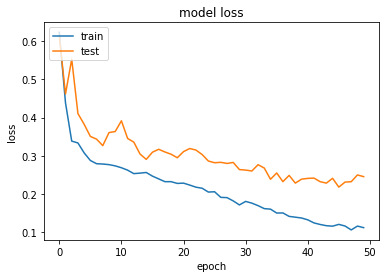

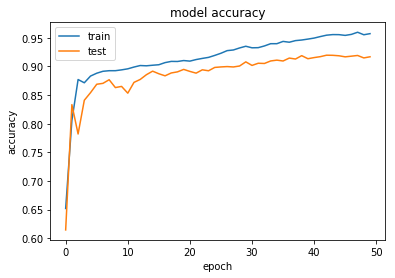

UNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 756
Max num of epochs: 50
Optimizer: ADAM
Batch size: 64
Loss function: Binary Cross-Entropy
Validation data percentage: 10
Early stoppping: Yes
-------------------------------------------------------------
#    Time sec      Tr_acc     Tr_loss      Vl_acc     Vl_loss
-------------------------------------------------------------
0   31.099800   0.652000    0.623600    0.614500    0.613128
1   28.646200   0.805700    0.438500    0.833400    0.461791
2   28.348900   0.877200    0.338300    0.782100    0.552976
3   28.722900   0.871500    0.333500    0.841000    0.410417
4   28.495200   0.883300    0.307500    0.854300    0.382405
5   28.323700   0.888300    0.287500    0.869000    0.350593
6   28.262900   0.891600    0.279000    0.870500    0.343413
7   28.393800   0.892600    0.278200    0.876900    0.326401
8   28.389900   0.892700    0.276600    0.863200    0.360584
9   28.409

In [13]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [7]:
# Predict on train and validation tests
model = load_model('model-withouvdm-3Mar2019.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.7)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.7):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

NameError: name 'X_train' is not defined

In [71]:
# Sanity check on random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

NameError: name 'preds_train_t' is not defined

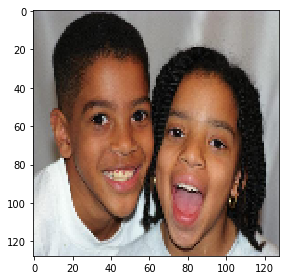

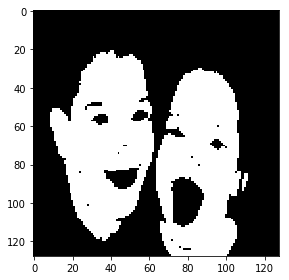

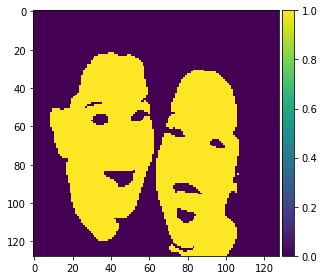

In [53]:
# Sanity check on random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.7):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.7):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [21]:
model = load_model('model-withouvdm-abd-3Mar2019.h5', custom_objects={'mean_iou': mean_iou})
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'

# ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/testing_data/'
# MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset_Test/ground_truth/'

# ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/original_images/'
# MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/skin_masks/'

abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()
# abd_ids = abd_ids[-90:]
# msk_ids = msk_ids[-90:]

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)
    
    if img.ndim == 3:
        img = img[:,:,1]
        
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True)
    if (np.unique(img).size) > 2:
        img = img > 30           # Important, Needed to make labels 0's and 1's only   
    else:   
        img = img > 0
    img = img.astype(np.uint8)
    msk[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Overall accuracy on abdomen pictures
answer = acc_comp(msk, preds_test_t)
print(answer)


100/100 [==============================] - 1s 15ms/step
(0.949968, 0.113345, array([ 6627.,  7197.,  6771., 10524.,  1246.,  7141.,  9049.,  7035.,
        9348.,  9135.,  6033.,  4365.,  6441., 13083.,  8966.,  4751.,
       12283., 14770., 10497.,  8323., 12329.,  4945.,  5775.,  5374.,
        5500.,  7861.,  9419.,  4849.,  8180.,  7026.,  8866.,  7142.,
        8859.,  8557.,  7608., 11505., 11779.,  6974., 10049., 12859.,
        7436., 12701.,  3386.,  7556.,  5793.,  5301.,  4663.,  6289.,
        8137., 10588.,  6774., 12670.,  5399., 11748.,  3211.,  4251.,
       10217., 10684.,  3922.,  6463.,  8156.,  5463., 12196., 12907.,
        6118.,  8855.,  7840.,  7973.,  3778.,  8511.,  6638.,  4074.,
        7145.,  5856.,  7279., 11699., 11201.,  8005.,  9062.,  8766.,
        6589., 14998.,  3111.,  5747.,  3032.,  4838.,  3503., 10736.,
        5089.,  7842.,  4047.,  4966.,  4603.,  1249.,  1868.,  9358.,
        7484., 10657.,  9214.,  9222.]), array([ 9622.,  8941.,  8898.

In [18]:
a = np.reshape(answer[2],(100,1))
b = np.reshape(answer[3],(100,1))
c = np.reshape(answer[4],(100,1))
d = np.reshape(answer[5],(100,1))
g = np.concatenate([a,b,c,d],axis = 1)
print(g)
np.save('UNET_FSD.npy',g)

[[1.3213e+04 2.8800e+03 1.1000e+01 2.8000e+02]
 [1.4616e+04 8.5100e+02 3.2000e+01 8.8500e+02]
 [1.3517e+04 2.6930e+03 1.0900e+02 6.5000e+01]
 [1.2085e+04 3.6710e+03 1.4900e+02 4.7900e+02]
 [1.2456e+04 3.5510e+03 1.0400e+02 2.7300e+02]
 [5.6190e+03 9.5400e+03 2.1700e+02 1.0080e+03]
 [1.3596e+04 1.5110e+03 1.3800e+02 1.1390e+03]
 [9.9050e+03 4.7400e+03 5.4000e+02 1.1990e+03]
 [1.3646e+04 2.2240e+03 2.2700e+02 2.8700e+02]
 [1.3977e+04 2.1560e+03 1.4800e+02 1.0300e+02]
 [1.4740e+04 1.3460e+03 1.0800e+02 1.9000e+02]
 [9.4570e+03 6.3100e+03 1.4800e+02 4.6900e+02]
 [1.2800e+04 3.0590e+03 9.2000e+01 4.3300e+02]
 [1.3333e+04 2.4550e+03 2.2100e+02 3.7500e+02]
 [9.4900e+03 6.3350e+03 3.3000e+01 5.2600e+02]
 [1.3192e+04 3.0080e+03 5.8000e+01 1.2600e+02]
 [1.3853e+04 2.4000e+03 6.9000e+01 6.2000e+01]
 [1.3460e+04 2.6870e+03 6.9000e+01 1.6800e+02]
 [1.1685e+04 4.0840e+03 2.8600e+02 3.2900e+02]
 [1.0320e+04 5.3410e+03 1.7100e+02 5.5200e+02]
 [1.3362e+04 2.5840e+03 2.9000e+01 4.0900e+02]
 [9.4470e+03 

In [10]:
# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/Friends/'

abd_ids = next(os.walk(ABD_PATH))[2]
abd_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img
    
# Actual Predictions
preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

KeyboardInterrupt: 

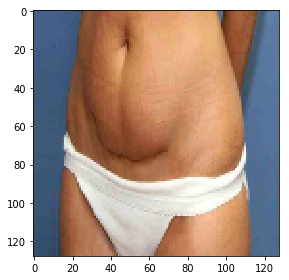

0


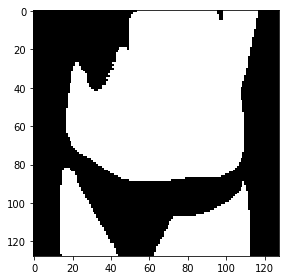

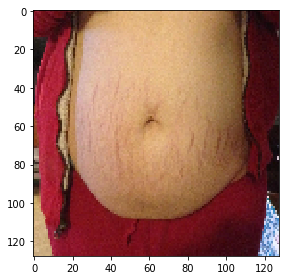

1


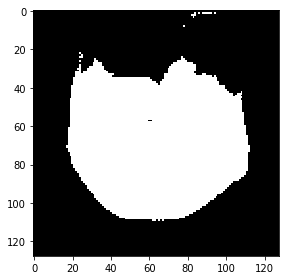

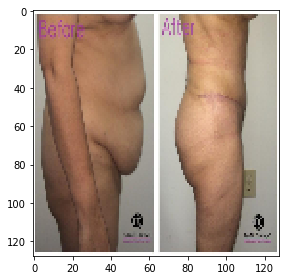

2


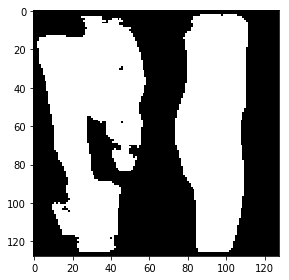

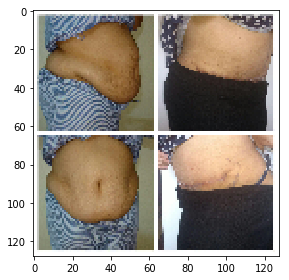

3


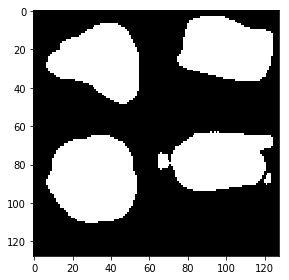

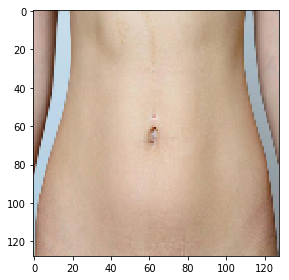

4


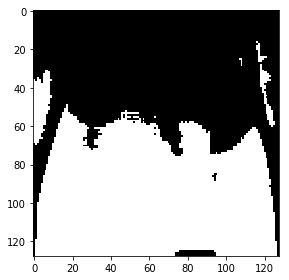

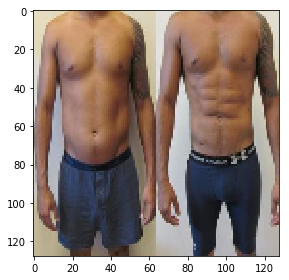

5


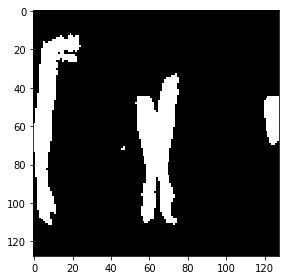

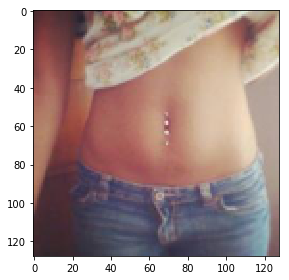

6


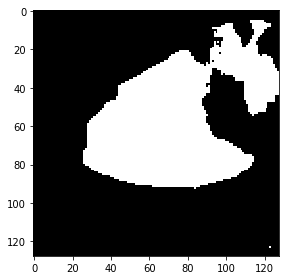

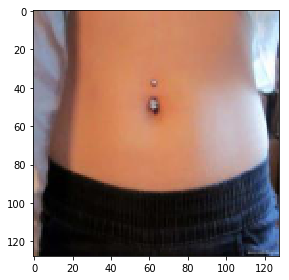

7


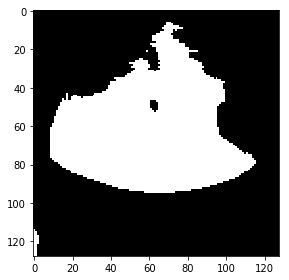

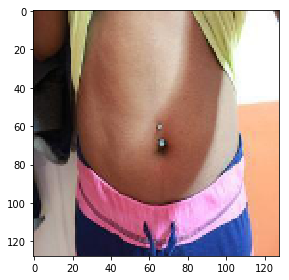

8


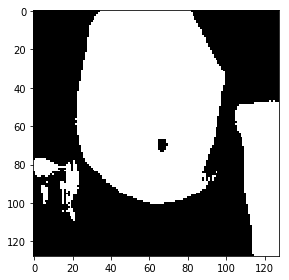

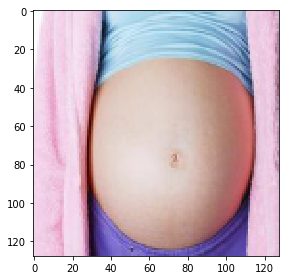

9


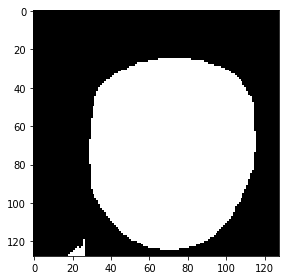

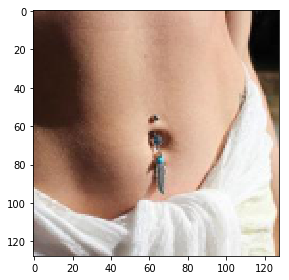

10


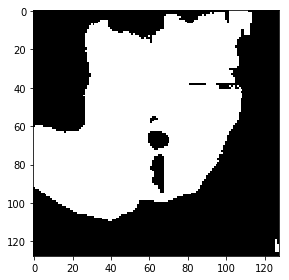

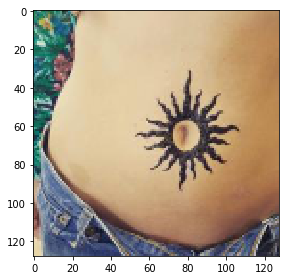

11


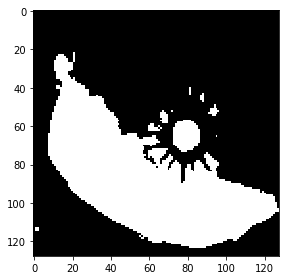

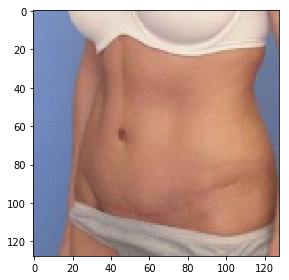

12


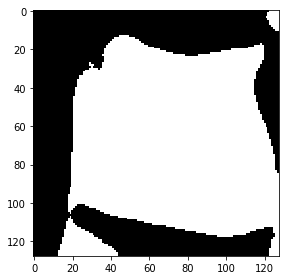

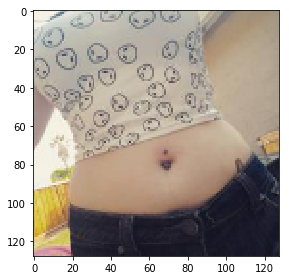

13


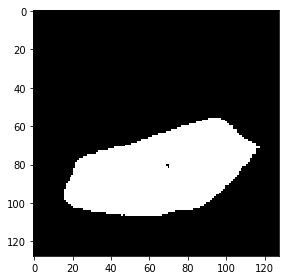

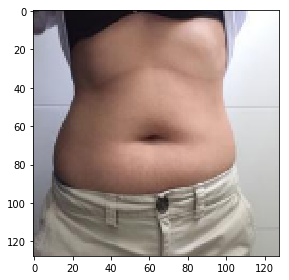

14


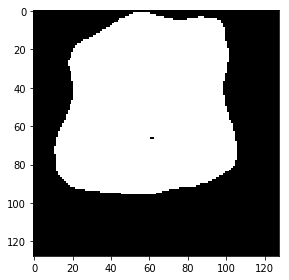

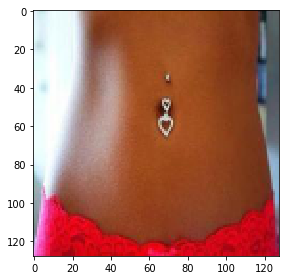

15


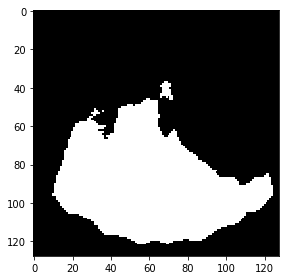

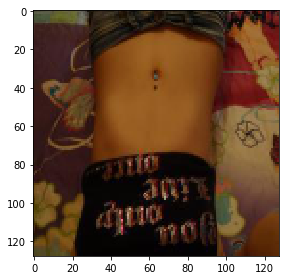

16


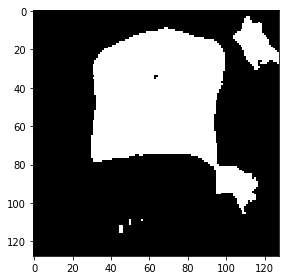

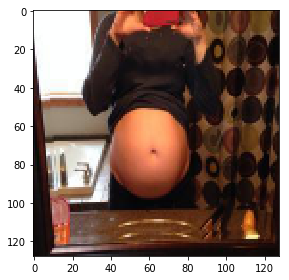

17


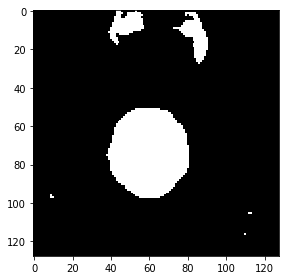

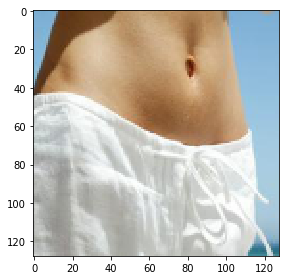

18


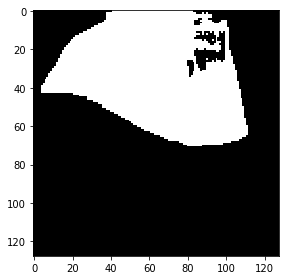

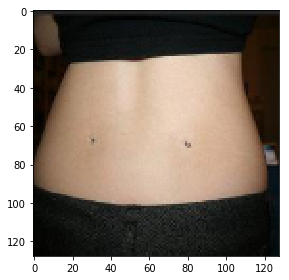

19


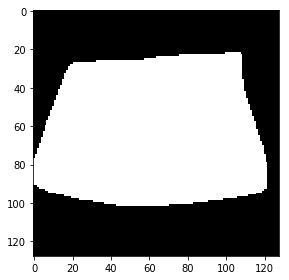

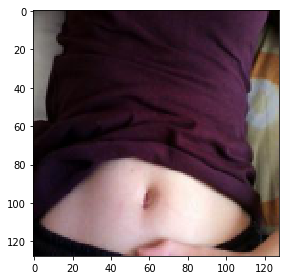

20


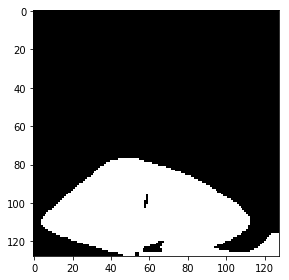

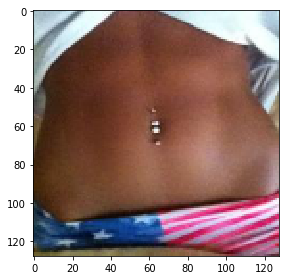

21


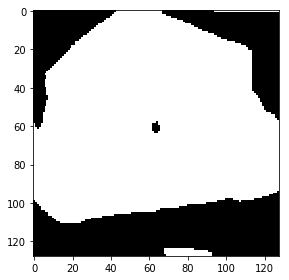

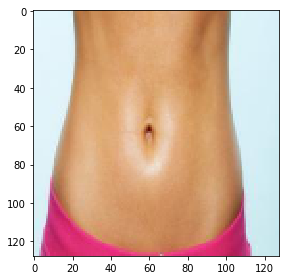

22


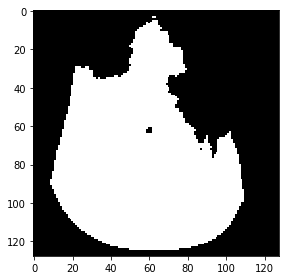

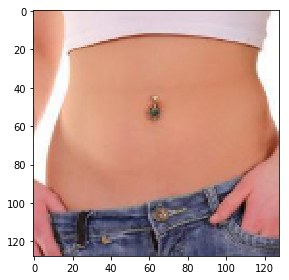

23


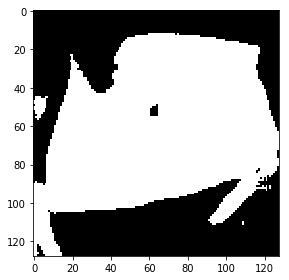

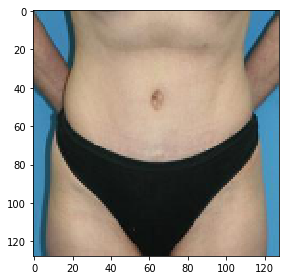

24


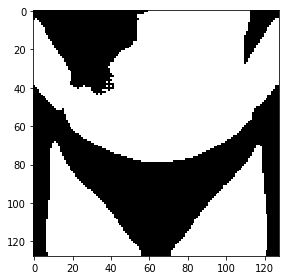

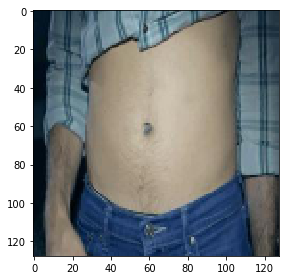

25


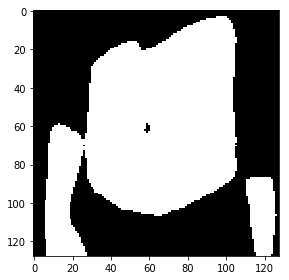

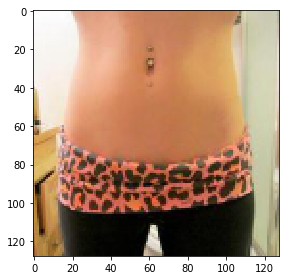

26


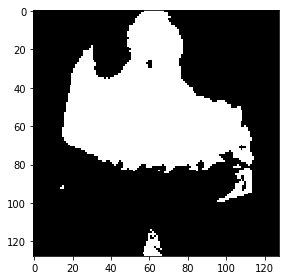

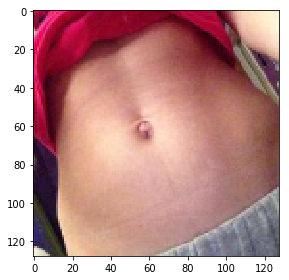

27


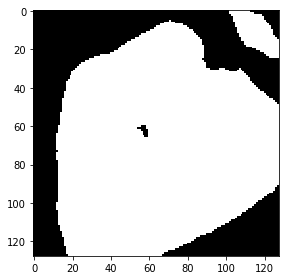

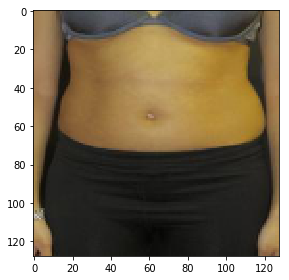

28


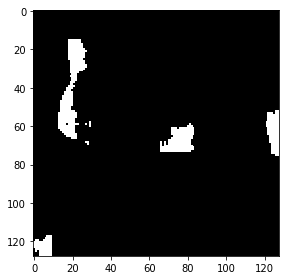

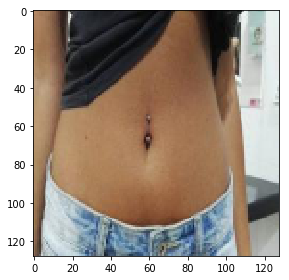

29


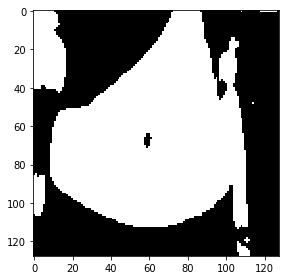

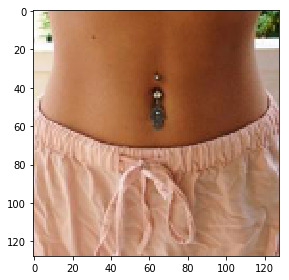

30


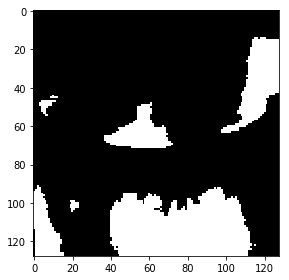

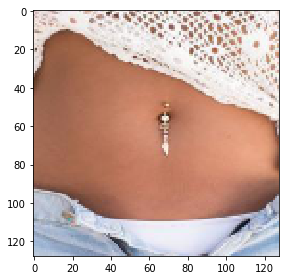

31


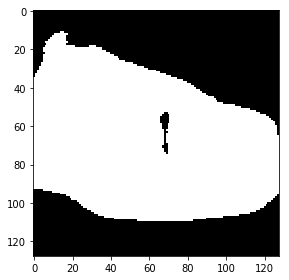

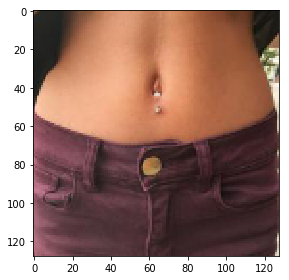

32


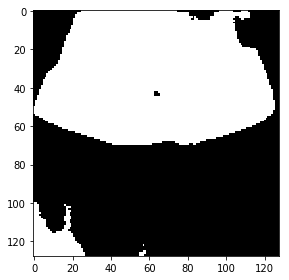

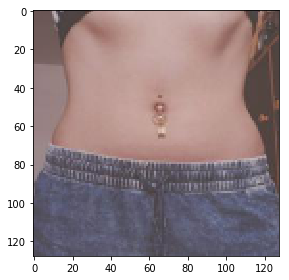

33


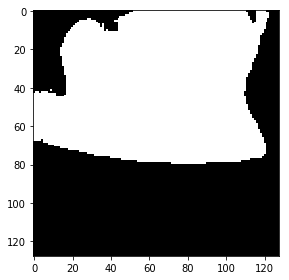

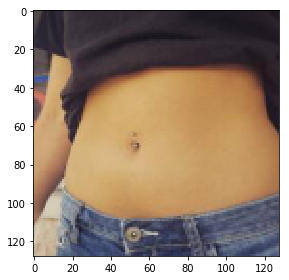

34


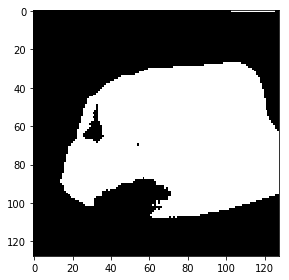

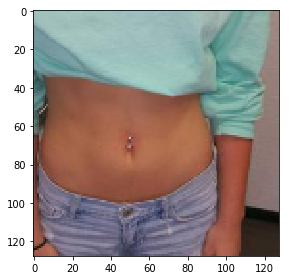

35


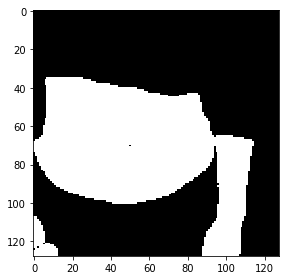

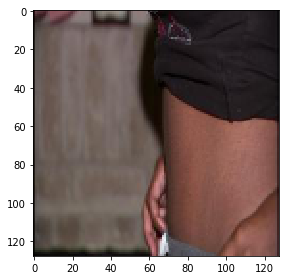

36


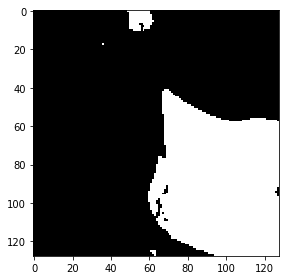

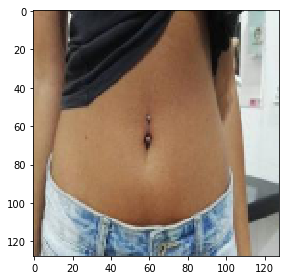

37


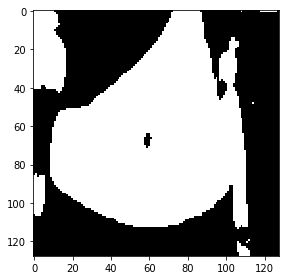

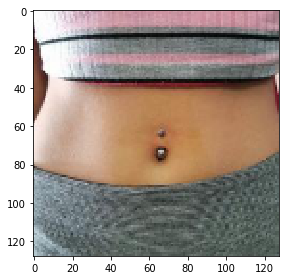

38


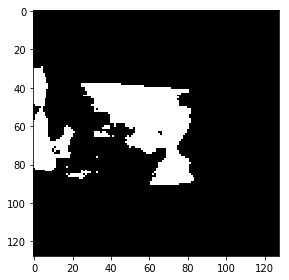

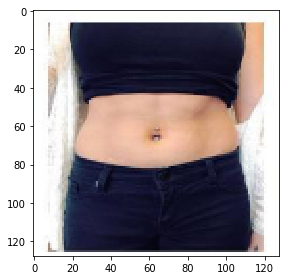

39


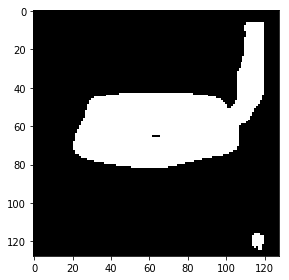

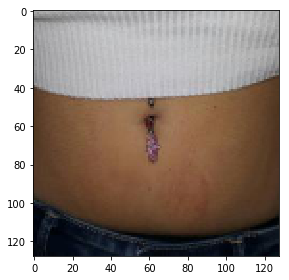

40


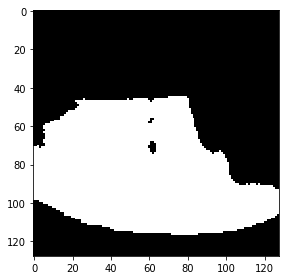

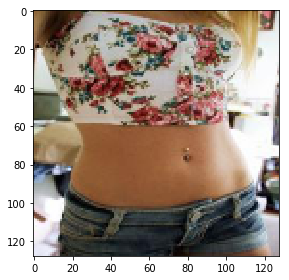

41


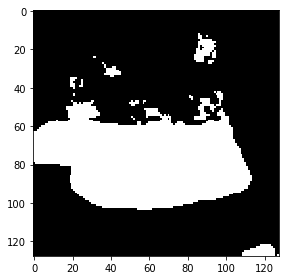

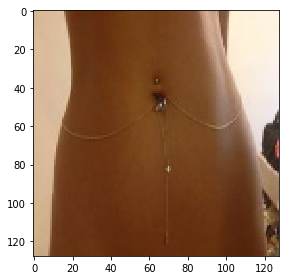

42


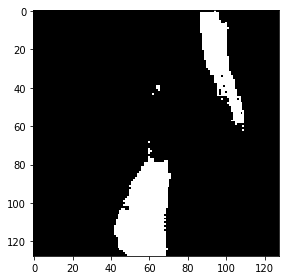

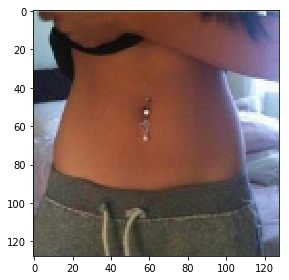

43


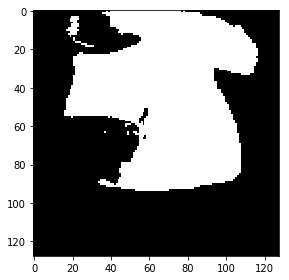

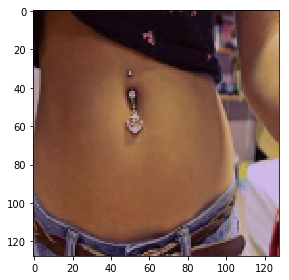

44


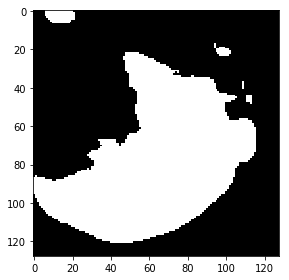

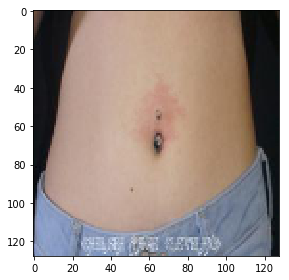

45


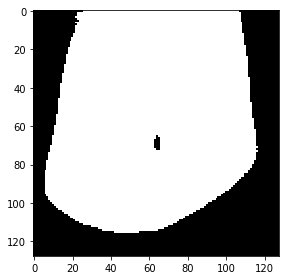

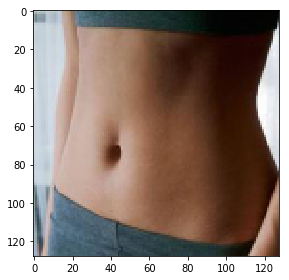

46


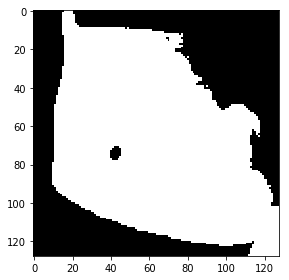

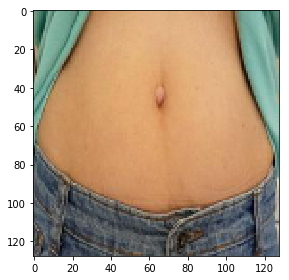

47


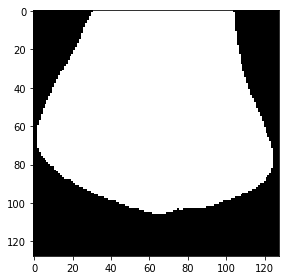

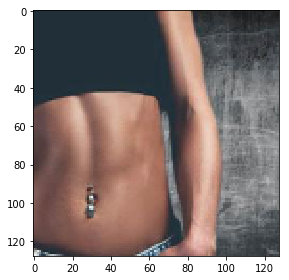

48


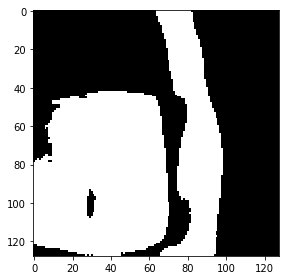

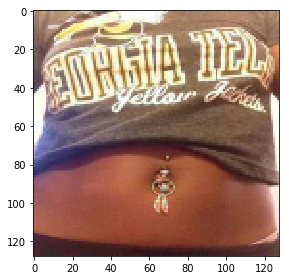

49


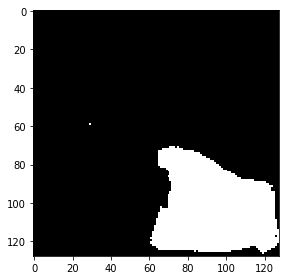

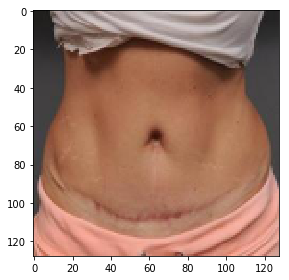

50


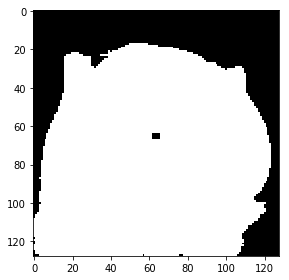

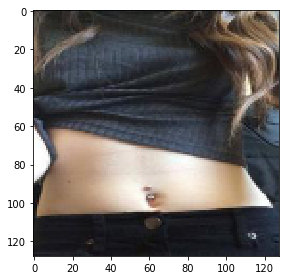

51


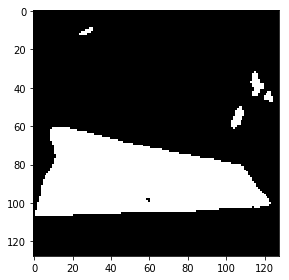

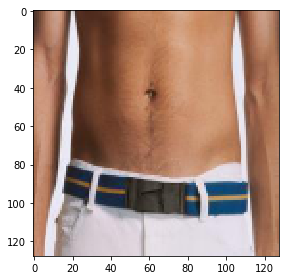

52


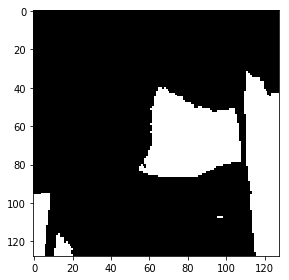

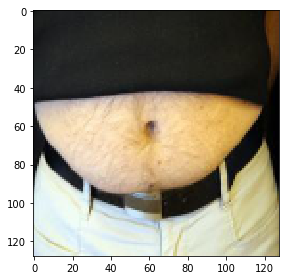

53


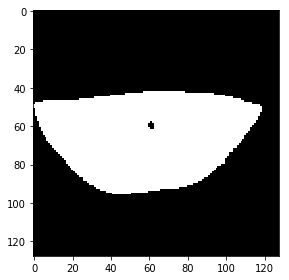

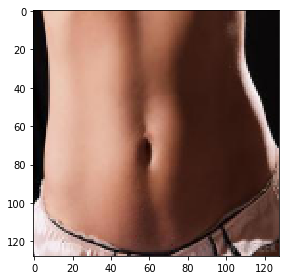

54


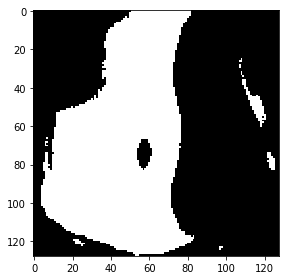

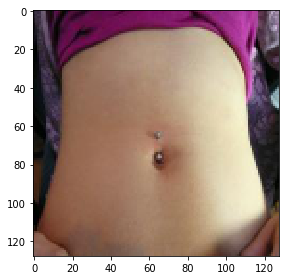

55


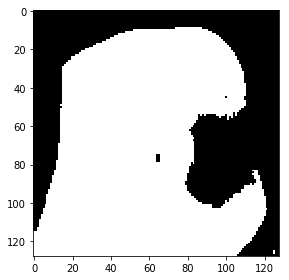

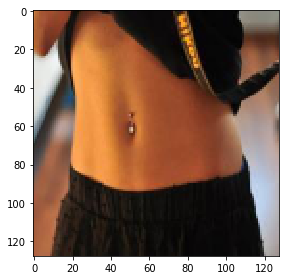

56


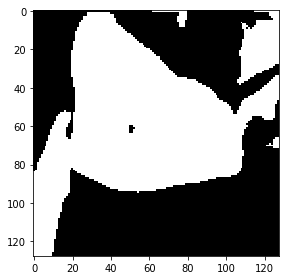

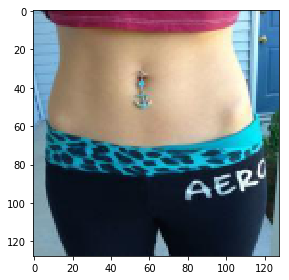

57


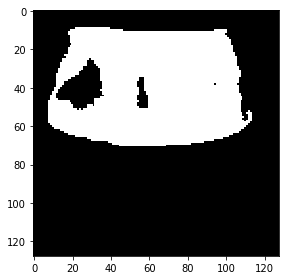

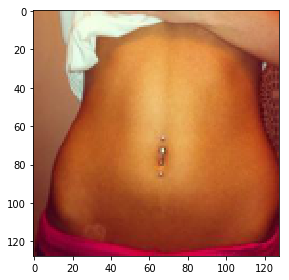

58


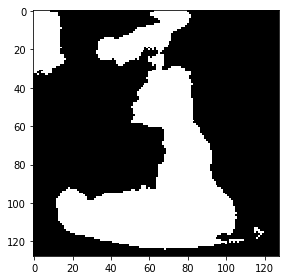

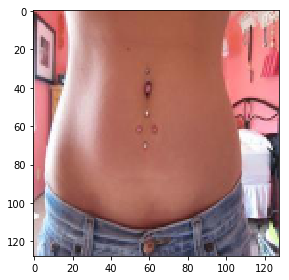

59


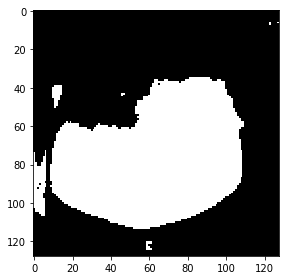

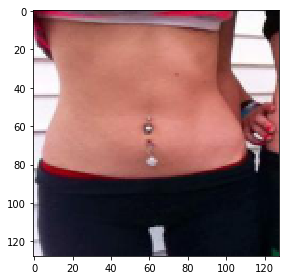

60


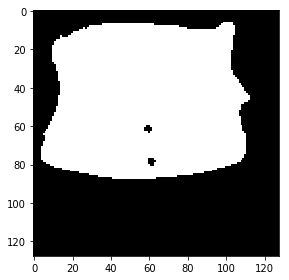

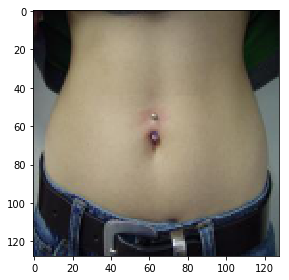

61


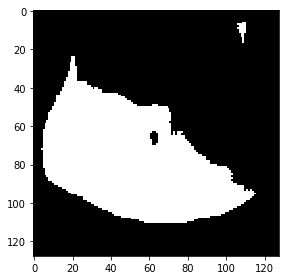

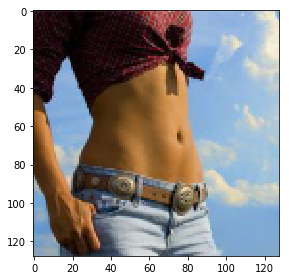

62


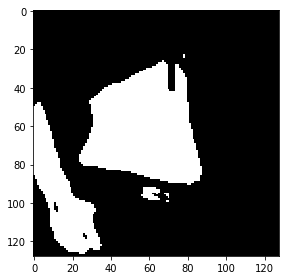

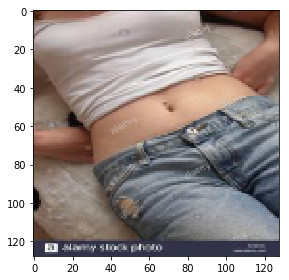

63


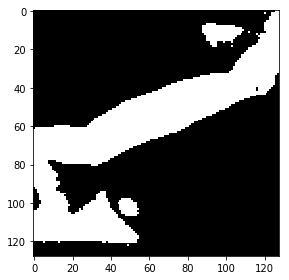

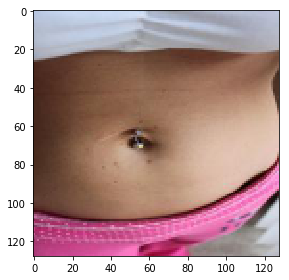

64


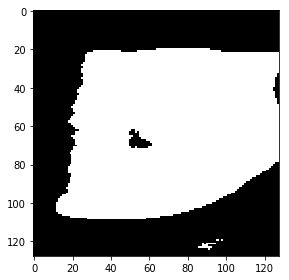

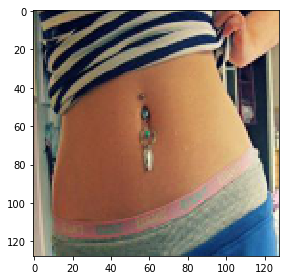

65


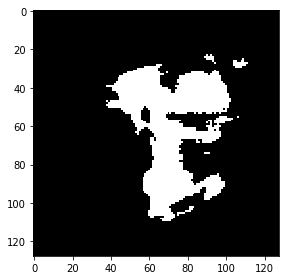

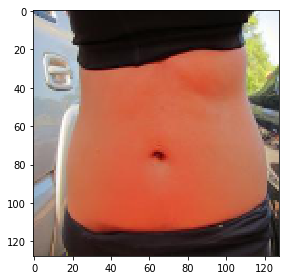

66


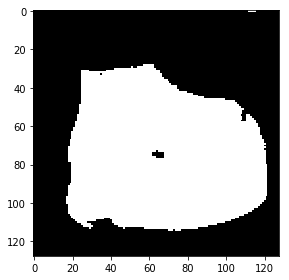

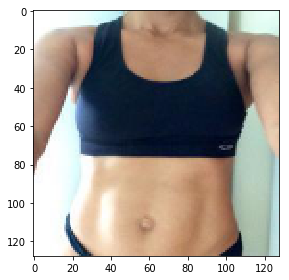

67


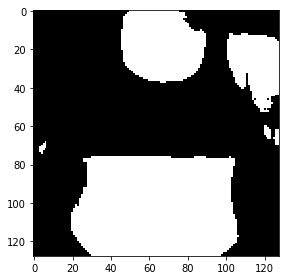

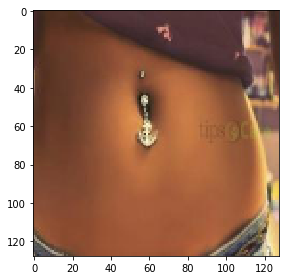

68


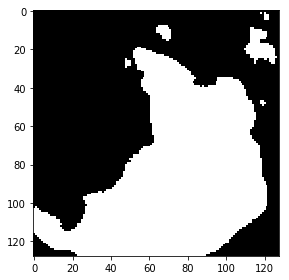

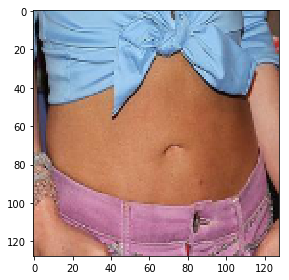

69


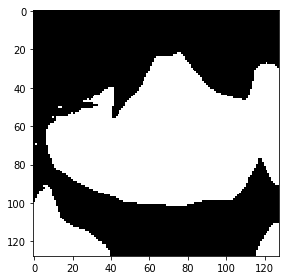

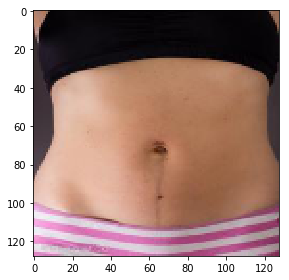

70


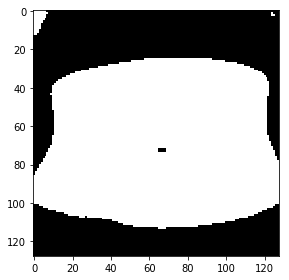

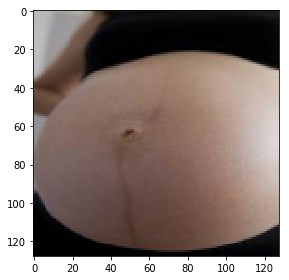

71


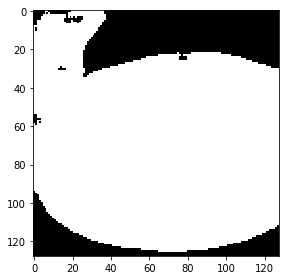

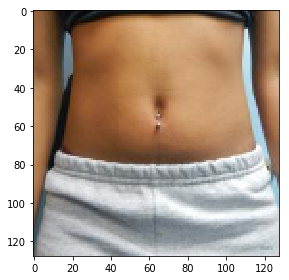

72


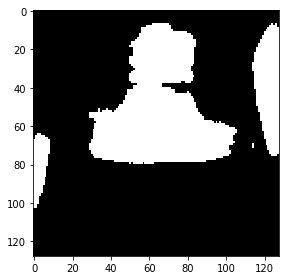

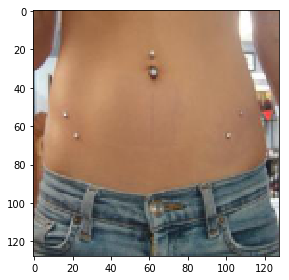

73


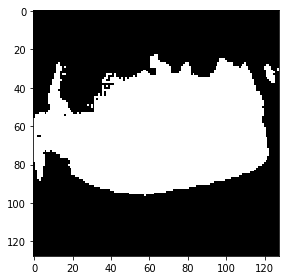

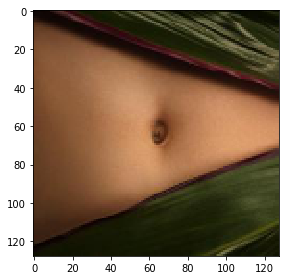

74


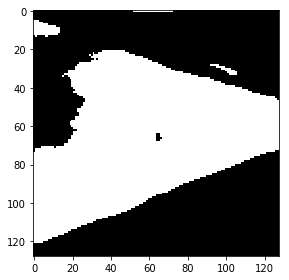

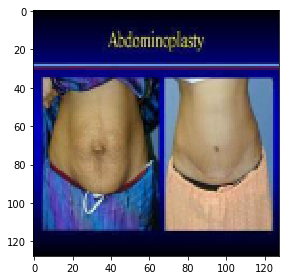

75


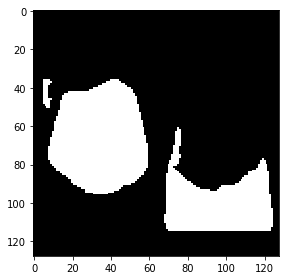

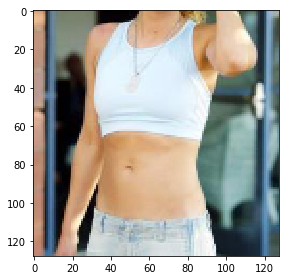

76


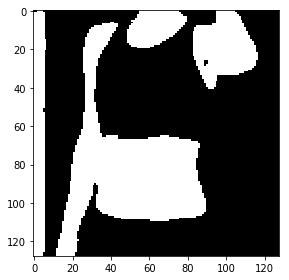

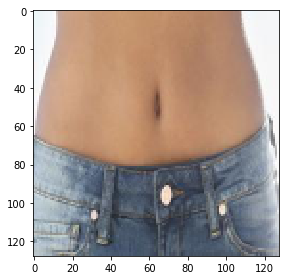

77


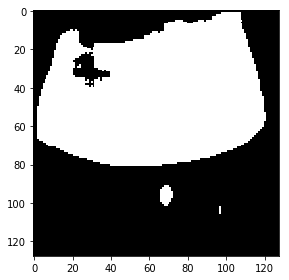

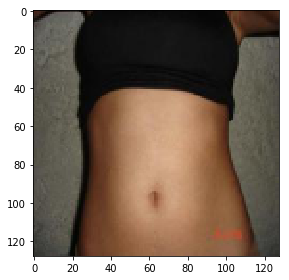

78


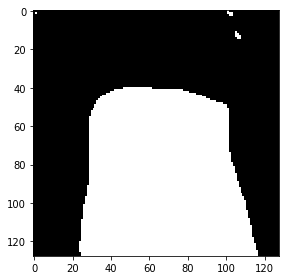

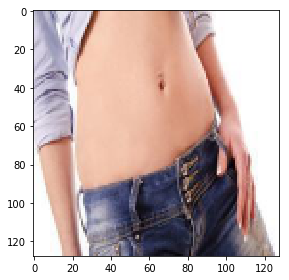

79


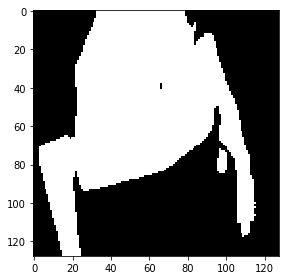

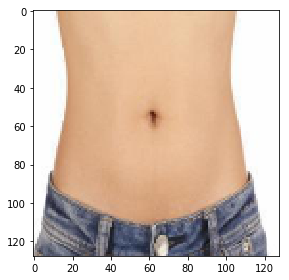

80


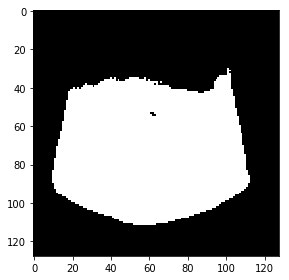

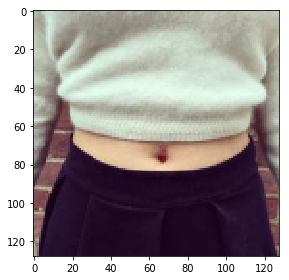

81


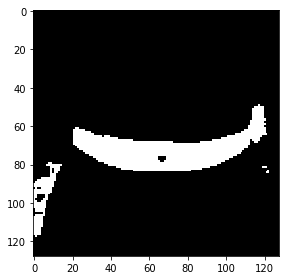

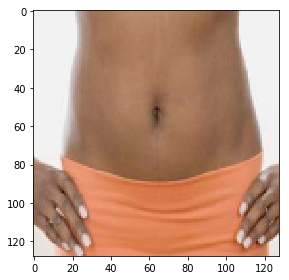

82


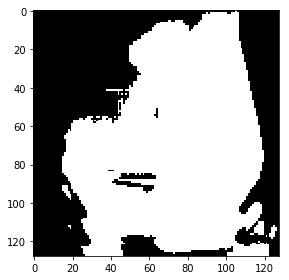

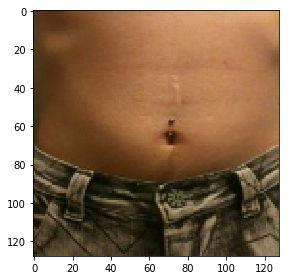

83


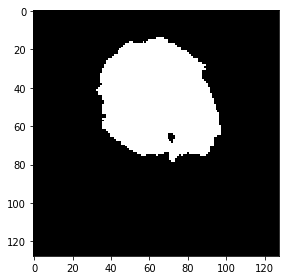

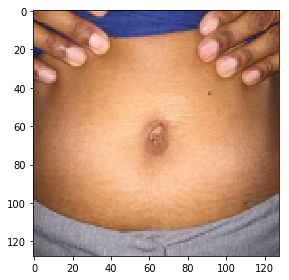

84


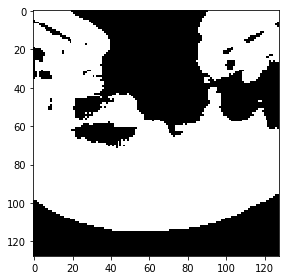

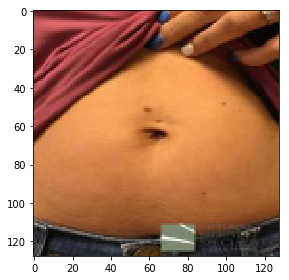

85


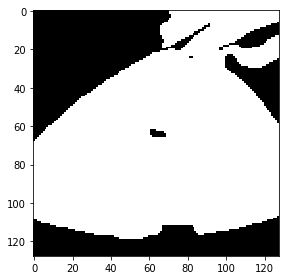

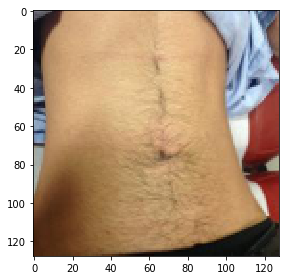

86


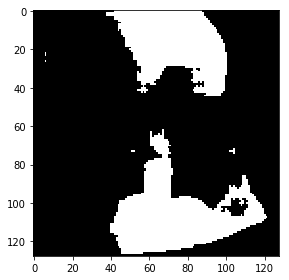

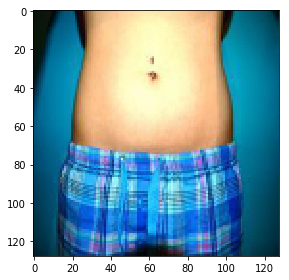

87


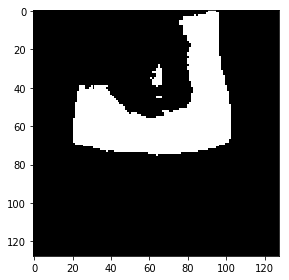

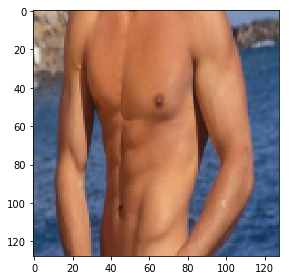

88


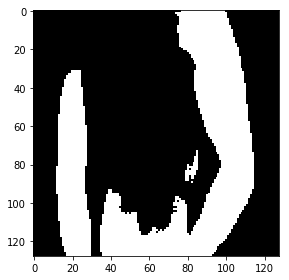

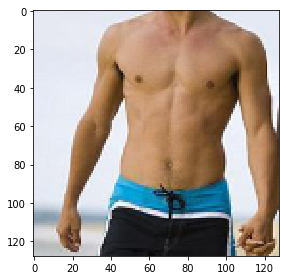

89


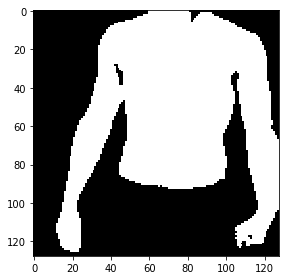

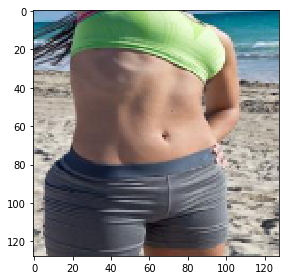

90


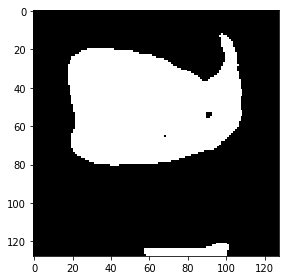

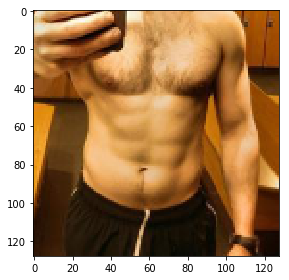

91


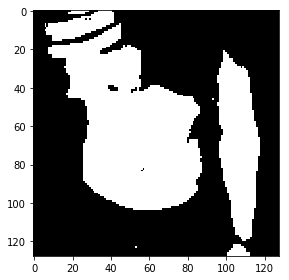

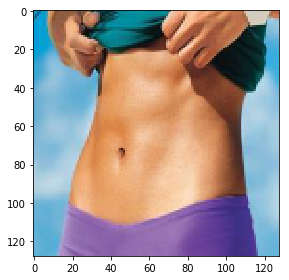

92


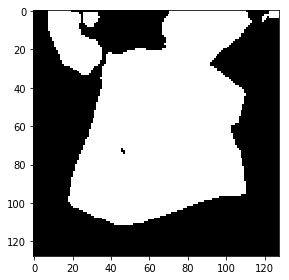

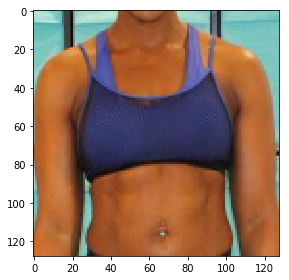

93


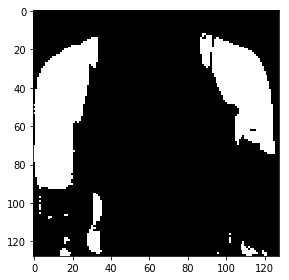

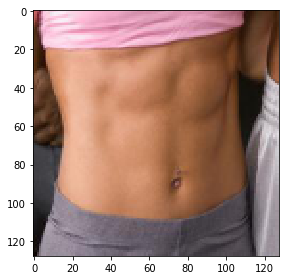

94


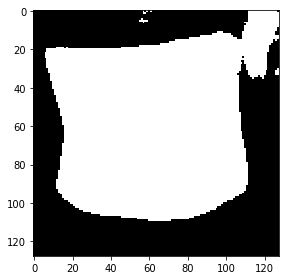

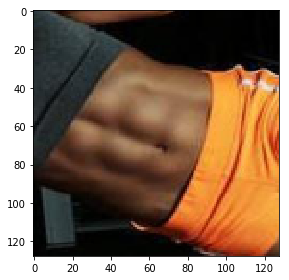

95


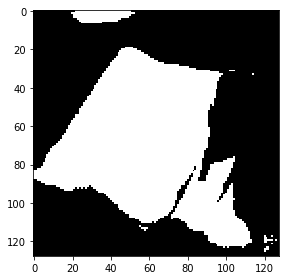

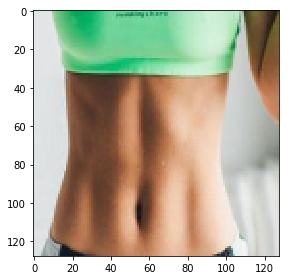

96


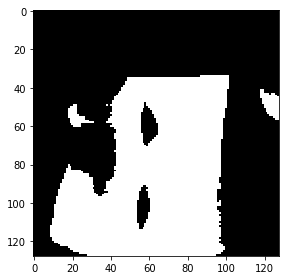

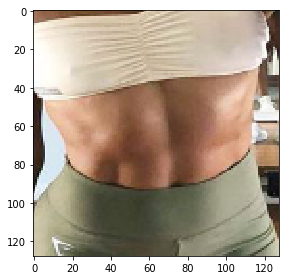

97


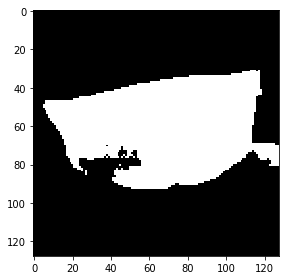

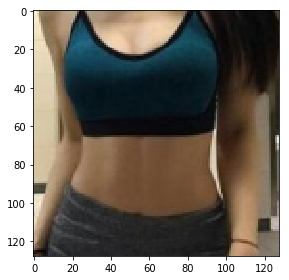

98


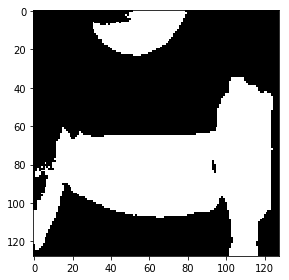

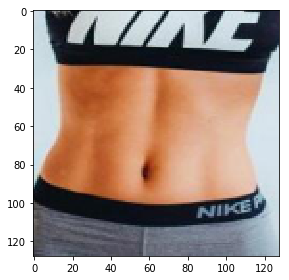

99


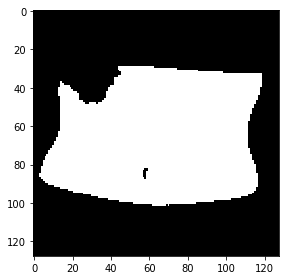

In [8]:
for j in range(len(abd_ids)):
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    print(j)
#     plt.show()
#     imshow(np.squeeze(msk[j]))

In [26]:
cv.imwrite('un65.jpg',preds_test_t[65]*255)

True